In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os
from torchvision.io import read_image
from PIL import Image
import pandas as pd

# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Conv3d
from torch.optim import Adam, SGD


niftypath = "/mnt/c/Users/Patrick/Documents/MPHYS_DATA_NIFTY"
croppath = "/mnt/c/Users/Patrick/Documents/MPHYS_DATA_CROPPED"

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

In [2]:
idx = 0
transform = ToTensor()

class CustomImageDataset():
    def __init__(self, croppath, transform=None, target_transfrom=None):
        #self.img_labels = pd.read_csv("/mnt/c/Users/Patrick/Documents/NSCLC Radiomics Lung1.clinical-version3-Oct 2019(1).csv")
        self.img_labels = pd.read_csv("/mnt/c/Users/Patrick/Documents/cancerdata.csv")
        #print(self.img_labels)
        self.img_dir = croppath
        self.transform=transform
        #print(self.transform)
        self.target_transform=target_transfrom

    def __len__ (self):
        return len(self.img_labels)

    def __getitem__ (self, idx):
        img_path = os.path.join(self.img_dir, f"{self.img_labels.iloc[idx, 0]}-RTSTRUCT.nii")
        image = sitk.ReadImage(img_path)
        array = sitk.GetArrayFromImage(image)
        #tensor = torch.from_numpy(array)
        time_to_death = self.img_labels.iloc[idx,8]
        dead_status = self.img_labels.iloc[idx,9]
        if time_to_death < 1.5*365 and dead_status == 1:
            label=1
        else:
            label=0
        #print(label)
        return(array, label)
dataset = CustomImageDataset(croppath, ToTensor(), None)
#print(len(dataset))

trainset, valset, testset = torch.utils.data.random_split(dataset, [14,3,3])

# for i in range(14):
#     train_x = trainset.__getitem__(i)[0]
#     train_y = trainset.__getitem__(i)[1]

# for i in range(3):
#     val_x = trainset.__getitem__(i)[0]
#     val_y = trainset.__getitem__(i)[1]
#     test_x = trainset.__getitem__(i)[0]
#     test_y = trainset.__getitem__(i)[1]




In [ ]:
print(dataset.__getitem__(0))

In [ ]:
xyz = dataset.__getitem__(12)[0]
print(xyz)

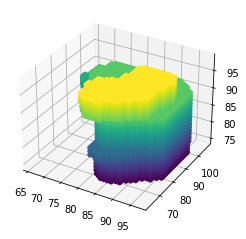

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
z,x,y = np.argwhere(xyz)
ax.scatter(x,y,z,c=z,alpha = 1)
plt.show()

In [3]:
train_dataloader = DataLoader(trainset, batch_size=4, shuffle=True)
train_features = next(iter(train_dataloader))
test_dataloader = DataLoader(testset, batch_size=4, shuffle=True)
test_features = next(iter(train_dataloader))
val_dataloader = DataLoader(valset, batch_size=4, shuffle=True)
val_features = next(iter(val_dataloader))


In [3]:
train_x = []
train_y = []
val_x = []
val_y = []
for i in range(14):
    train_x.append(trainset.__getitem__(i)[0])
    train_y.append(trainset.__getitem__(i)[1])
for i in range(3):
    val_x.append(valset.__getitem__(i)[0])
    val_y.append(valset.__getitem__(i)[1])

In [4]:
train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)

In [14]:
print(train_x.shape)

(14, 172, 172, 172)


In [5]:
train_x = train_x.reshape(14, 1, 172, 172, 172)
train_x = torch.from_numpy(train_x)

train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

val_x = val_x.reshape(3, 1, 172, 172, 172)
val_x = torch.from_numpy(val_x)

val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)



In [36]:
print(val_y.shape)

torch.Size([3])


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv3d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),#normalises batch
            ReLU(inplace=True),#applies a ReLu to the neurons
            MaxPool2d(kernel_size=2, stride=2),#finds max pool of feature map
            # Defining another 2D convolution layer
            Conv3d(4, 4, kernel_size=3, stride=1, padding=1),#64 neurons per layer
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)#calls the constructor to execute the convolutions, passes the tensor x and gets the 
        #result of the convolution passed back.
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x




cpu


In [7]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [58]:
def train(epoch):
    model.train()
    tr_loss = 0
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    # getting the training set
    print("1")
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    print("2")
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    print("3")
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    print("4")
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    print("5")
    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    print("6")
    # computing the updated weights of all the model parameters
    loss_train.backward()
    print("7")
    optimizer.step()
    print("8")
    tr_loss = loss_train.item()
    print("9")
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [59]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    print("program starts")
    train(epoch)